# DatasetとDataLoaderの実装

## 学習目標
1.	物体検出で使用するDatasetクラスを作成できるようになる(分類と違ってアノテーションデータあり)
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する
3. 物体検出で使用するDataLoaderクラスを作成できるようになる

## library

In [23]:
import os.path as osp
import cv2
import random
# xmlを読み込み、加工、保存するライブラリ
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

## 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する

In [24]:
def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する
    
    Params:
    -------------
    rootpath : str
        データフォルダへのパス
    
    Returns:
    -------------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データのへのパスを格納したリスト      
    """
    
    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_tempate = osp.join(rootpath, 'Annotations', '%s.xml')
    
    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names  = osp.join(rootpath+'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath+'ImageSets/Main/val.txt')
    
    # 訓練データの画像ファイルとアノテーションファイルへのパスのリストを作成
    trian_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)      # 画像のパス  なぜタプルで囲む必要があるのか
        anno_path = (annopath_tempate % file_id)   # アノテーションのパス
        trian_img_list.append(img_path)               # リストに追加
        train_anno_list.append(anno_path)           # リストに追加
    
    # 検証データの画像ファイルとアノテーションファイルへのパスのリストを作成
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)      # 画像のパス
        anno_path = (annopath_tempate % file_id)   # アノテーションのパス
        val_img_list.append(img_path)               # リストに追加
        val_anno_list.append(anno_path)           # リストに追加
    
    return  trian_img_list, train_anno_list, val_img_list, val_anno_list

In [25]:
# template test
test_path = osp.join('JPEGImages', '%s.jpg')
file_id  = '000000'
img_path = (test_path % file_id)  
print(img_path)

JPEGImages/000000.jpg


In [26]:
# ファイルパスのリストを作成
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 動作確認
print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations/2008_000008.xml


In [27]:
# listにlist足したらどうなるのか
ret = []
a = ['a', 'i', 'u', 'e' ,'o']
b = ['ka', 'ki', 'ku', 'ke' ,'ko']
ret += a 
print(ret)
ret += b
print(ret)

['a', 'i', 'u', 'e', 'o']
['a', 'i', 'u', 'e', 'o', 'ka', 'ki', 'ku', 'ke', 'ko']


In [28]:
# listをlistで囲ってlistに足したらどうなるのか
ret = []
a = ['a', 'i', 'u', 'e' ,'o']
b = ['ka', 'ki', 'ku', 'ke' ,'ko']
ret += [a] 
print(ret)
ret += [b]
print(ret)

# これをnumpyにしたら
import numpy as np
np.array(ret)

[['a', 'i', 'u', 'e', 'o']]
[['a', 'i', 'u', 'e', 'o'], ['ka', 'ki', 'ku', 'ke', 'ko']]


array([['a', 'i', 'u', 'e', 'o'],
       ['ka', 'ki', 'ku', 'ke', 'ko']], dtype='<U2')

## xml形式のアノテーションデータをリストに変換

In [29]:
# XML形式のアノテーションデータをpythonのリスト形式に変換するクラス

class Anno_xml2list(object):
    """
    一枚の画像に対する「ｘml形式のアノテーションデータ」を画像サイズに規格化してからリスト形式に変換する
    
    Attributeｓ
    -------------
    classes : list
        VOCのクラス名を格納したリスト
    """
    
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, width, hetig):
        """
        一枚の画像に対する「ｘml形式のアノテーションデータ」を画像サイズに規格化してからリスト形式に変換する
        
        Params
        -------------
        xml_path : str
            xmlファイルへのパス
        width : int
            対象画像の幅
        height : int
            対象画像の高さ
            
        Returns
        -------------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ...]
            物体のアノテーションデータを格納したリスト
            画像内に存在する物体数分の要素を持つ
            一つの画像につき５つの値が与えられている
        """
        
        # 画像内の全ての物体のアノテーションをこのリストに格納
        ret = []
        
        # xmlファイルの読み込み
        xml = ET.parse(xml_path).getroot()
        
        # 画像内にある物体(object)の数だけループする
        for obj in xml.iter('object'):
            # アノテーションで検知がdifficultに設定されているものを除外
            difficult = int(obj.find('difficult').text)   # この書きかた分かってない　find()
            if difficult == 1:
                continue
            
            # 一つの物体に対するアノテーションを格納するリスト
            bndbox = []
            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')                                      # バウンディングボックスの情報
            
            # アノテーションの xmin, ymin, xmax, ymax, label_ind を取得し、0-1に正規化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in (pts):
                # なぜタプルで囲ったのか
                # 原点が(1,1)なので(0,0)に修正
                cur_pixel = int(bbox.find(pt).text) - 1
                
                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':       # x軸の方向のときは幅で割り算
                    cur_pixel  /= width
                else:                                                    # y軸のときは高さで割り算
                    cur_pixel /= height
                
                bndbox.append(cur_pixel)
                
            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            # res に[[xmin, ymin, xmax, ymax, label_ind]]を追加する
            ret += [bndbox]
            
        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ...]

In [30]:
# Anno_xml2listの動作確認
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 
               'diningtable', 'dog', 'horse', 'motorbike', 
               'person', 'pottedplant', 'sheep', 'sofa', 
              'train', 'tvmonitor']

# ここで__init__
transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み　OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)   # 高さ、幅、色RGB
height, width, channels = img.shape   # 画像サイズの取得

# アノテーションをリストで表示
# ここで__call__
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

## 画像とアノテーションの前処理を行うクラスDataTransformを作成

In [31]:
# utils配下にあるライブラリを使う
# 入力画像の前処理クラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, RandomSampleCrop, Expand, RandomMirror, PhotometricDistort, Resize, ToPercentCoords, SubtractMeans

class DataTransform():
    """
    画像とアノテーションの前処理クラス
    訓練と推論で異なる動作をする
    訓練時はデータオーグメンテーション
    
    Attibutes
    -------------
    input_size : int
        リサイズ先の画像の大きさ
    color_mean : (B,G,R)
        各色チャネルの平均値
    """
    
    def __init__(self, input_size, color_mean):
#         self.input_size = input_size
#         self.color_mean = color_mean
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),          # int -> float32
                ToAbsoluteCoords(),       # アノテーションデータの規格化を戻す
                PhotometricDistort(),      # 画像の色調などをランダムに変化
                Expand(color_mean),       # 画像のキャンバスを広げる
                RandomSampleCrop(),     # 画像内の部分をランダムに抜き出す
                RandomMirror(),                # 画像反転
                ToPercentCoords(),          # アノテーションデータを0-1に規格化
                Resize(input_size),           # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)    # BGRの色の平均を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),          # int -> float32
                Resize(input_size),           # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)    # BGRの色の平均を引き算
            ])
        }
    
    def __call__(self, img, phase, boxes, labels):
        """
        Params
        -------------
        phase : 'train' or 'val'
            前処理のモードを設定
        """
        return self.data_transform[phase](img, boxes, labels)
    

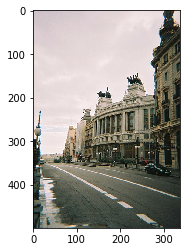

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


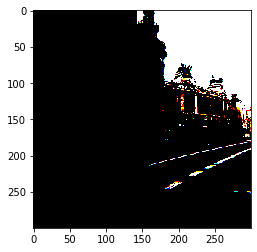

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


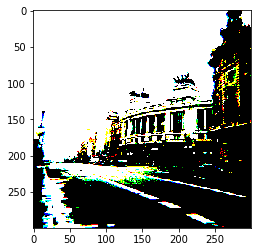

In [32]:
# DataTransformの動作確認

# 1. 画像の読み込み
ind = 63
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)   # 高さ、幅、色RGB
height, width, channels = img.shape   # 画像サイズの取得

# 2. アノテーションデータをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # RGBの色の平均値
input_size = 300                          # ssd300では300ｘ300
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = 'train'
img_transformed, boxes, labels = transform(
img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. val画像の表示
phase = 'val'
img_transformed, boxes, labels = transform(
img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# trainデータは毎実行で変わる
# valデータは変わらない

##  Datasetを作成

In [41]:
# これまではDatasetを作るために必要なものを作っていた
# pytorchのDatasetを継承してVOCDatasetクラスを作る

class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス
    pytorchのDatasetクラスを継承
    
    Attributes
    -------------
    img_list : list
        画像のパスを格納したリスト
    anno_list : list
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'val'
        学習か訓練化を設定する
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをlistに変換するインスタンス
    """
    
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
    
    def __len__(self):
        """
        画像の枚数を返す
        """
        return len(self.img_list)
    
    def __getitem__(self, index):
        """
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        """
        im, gt, h, w = self.pull_item(index)  # 下で実装
        return im, gt
    
    def pull_item(self, index):
        """
        前処理をした画像のテンソル形式のデータとアノテーション、画像の高さ、幅を取得
        """
        
        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)        # 高さ、幅、色BGR
        height, width, channels = img.shape       # 画像のサイズ取得
    
        # 2. xml形式のアノテーション情報をリスト型にする
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        # 3. 前処理を実施　ここでDataTransformを使う
        # 1枚の画像に対して可変長のbboxとlabelの組がある
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])  # 全てのboxの座標と全てのboxのラベルを分けて入れている
        #　BGR -> RGB
        # height, width, channel -> channel, height, width
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
        
        # BBoxトラベルをセットにしたnp.arrayを作成　gt : ground truth(答え)
        # 下のnp.expand_dimsとnp.hstackのデモ参照
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        return img, gt, height, width

In [42]:
# np.expand_dimsの確認
a = np.array([1,2,3,4,5])
print(a.shape)
b = np.expand_dims(a, axis=1)
print(b.shape)
c =  np.array([[10, 100], [20, 200], [30, 300], [40, 400], [50, 500]])
print(c.shape)
d = np.hstack((c, b))
print(d.shape)
d
# OK

(5,)
(5, 1)
(5, 2)
(5, 3)


array([[ 10, 100,   1],
       [ 20, 200,   2],
       [ 30, 300,   3],
       [ 40, 400,   4],
       [ 50, 500,   5]])

In [52]:
# Datasetの動作確認
color_mean = (104, 117, 123)  # BGR
input_size = 300                          # ssd300だからinput size を300x300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))
val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

# データの取り出し例
val_dataset.__getitem__(15)

(tensor([[[ -3.0400,   0.2200,   1.8500,  ...,  -4.3333,  -7.8900,  -8.2050],
          [  2.4950,   4.4950,   5.6600,  ...,  -3.9483,  -5.6700,  -5.6700],
          [  6.4667,   7.2750,   8.2667,  ...,  -2.0917,  -3.7250,  -3.5417],
          ...,
          [-19.2917, -21.9000, -26.6833,  ...,  -3.2083,  -4.6500, -13.1917],
          [-27.9033, -29.6800, -33.0650,  ...,   1.9483,  -3.8350, -13.1133],
          [-38.7833, -38.5600, -34.3150,  ...,  -0.8167,  -4.0000, -15.2233]],
 
         [[ 23.8500,  25.2200,  26.7400,  ...,  15.6667,  12.1100,  11.7950],
          [ 27.1650,  29.1650,  28.3300,  ...,  16.0517,  14.3300,  14.3300],
          [ 28.9167,  29.1750,  28.7167,  ...,  17.9083,  16.2750,  16.4583],
          ...,
          [ -0.2917,  -2.9000,  -8.6500,  ...,   2.4417,   6.3500,  -0.2000],
          [ -9.1817, -11.5150, -16.2333,  ...,   5.1133,   7.1650,   3.9483],
          [-19.8017, -20.5600, -17.0183,  ...,   1.2383,   5.1100,   2.4433]],
 
         [[ 41.9050,  44.220

In [60]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


##  DataLoaderの作成
データをミニバッチとして取り出すためのクラス \
物体検出では画像分類とは違い、一枚の画像に対してgtのサイズが（検出する物体の個数）異なっているため、一工夫が必要

データ取り出し関数collate_fnを別途作成する

In [53]:
# od : object detection
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像毎に異なる
    画像内の物体数が2個であれば(2, 5),  3個であれば(3, 5)というサイズになる
    アノテーションデータが可変長である場合に対応するDataLoaderを作成するために、新しいcollate_fnを作成
    collate_fn : pytorchでリストからmini-batchを作成する関数
    ミニバッチ分の画像が並んでいるリスト変数batchに、ミニバッチ番号を指定する次元を先頭に一つ追加してリストの形を変形
    """
    
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])                                           # sample[0]は画像img
        targets.append(torch.FloatTensor(sample[1]))    # sample[1]はアノテーションgt
        
    # imgsはミニバッチサイズのリストになっている
    # リストの要素はtorch.Size([3, 300, 300])
    # このリストをtorch.Size([batch_num, 3, 300 ,300])のテンソルに変換
    imgs = torch.stack(imgs, dim=0)
    
    # targetsはアノテーションデータの正解であるgtのリスト
    # リストのサイズはmini-batch size
    # リストのtergetsの要素は[n, 5]となる   n: 物体数
    # nは画像毎に異なり
    # ５は[xmin, ymin, xmax, ymax, class_index]
    
    return imgs, targets

In [57]:
# torch.stackの確認
a = torch.randn(3, 300, 300)
b = torch.ones(3, 300, 300)
l = [a, b]
print(len(l))
ab = torch.stack(l, dim=0)
print(ab.shape)

2
torch.Size([2, 3, 300, 300])


tensor([[-1.6681,  0.6013, -0.2062,  ...,  0.1481,  0.0209,  1.4058],
        [-1.4986,  0.3935,  0.9965,  ...,  0.9979,  0.3834,  0.2630],
        [-0.2996, -2.5910,  1.7784,  ...,  1.9526, -0.7987,  0.0817],
        ...,
        [-0.6998, -0.9249,  0.3102,  ...,  0.5095, -0.9332, -2.3961],
        [-2.7920, -0.3397,  0.1287,  ..., -0.2203, -0.8280, -1.2256],
        [-0.4917,  0.8339, -1.5120,  ..., -1.6464,  0.9299,  0.7390]])

In [64]:
# od_collate_fnを使ってデータローダーの作成
batch_size = 4

# torch.utils.dataより
# これは継承して自作DataLoaderクラスを作るのではなく、DataLoaderクラスからインスタンスを作成する
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# DataLoader は辞書型変数にまとめる
dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

# dataloaderの動作確認
batch_iterator = iter(dataloaders_dict['val'])        # イテレーターに変換
images, targets = next(batch_iterator)                   # １番目の要素を取り出す
print(images.size())
print(len(targets))
print(targets[1].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])
